# (a) Load data. Report the size of the positive (class 1) and negative (class 0) samples in dataset.

In [47]:
import pandas as pd

df = pd.read_csv("HW4_data/SVM_2025/svm_2025.csv")

display(df.head())
print(df.shape)

print(df["Class"].value_counts())

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Class
0,0.021,0.028,0.012,0.044,0.043,0.077,0.584,0.143,0.189,0.185,...,0.010,0.001,0.005,0.004,0.003,0.008,0.005,0.002,0.001,0
1,0.053,0.056,0.122,0.121,0.025,0.102,0.216,0.044,0.229,0.163,...,0.034,0.015,0.034,0.038,0.017,0.013,0.010,0.036,0.021,0
2,0.049,0.028,0.059,0.127,0.177,0.191,0.888,0.077,0.125,0.203,...,0.008,0.013,0.016,0.006,0.012,0.019,0.014,0.033,0.044,0
3,0.019,0.061,0.038,0.077,0.139,0.081,0.228,0.022,0.104,0.119,...,0.033,0.013,0.012,0.011,0.002,0.004,0.004,0.011,0.008,1
4,0.035,0.051,0.008,0.024,0.043,0.074,0.376,0.113,0.123,0.151,...,0.004,0.012,0.011,0.011,0.010,0.005,0.002,0.008,0.003,0


(156, 61)
Class
0    83
1    73
Name: count, dtype: int64


# (b) Use stratified random sampling to divide the dataset into training data (75%) and testing data (25%) [use random state= 42]. 
Report the number of positive and negative samples in both training and testing data.

In [48]:
from sklearn.model_selection import train_test_split

label_col = 'Class'

# Split X, y
X = df.drop(columns=[label_col])
y = df[label_col].astype(int)

# Stratified random sampling
X_traing, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("(b) Train/Test Class distribution: 1 positive sample, 0 negative sample")
print(" Train:", y_train.value_counts().sort_index().to_dict())
print(" Test :", y_test.value_counts().sort_index().to_dict())

(b) Train/Test Class distribution: 1 positive sample, 0 negative sample
 Train: {0: 62, 1: 55}
 Test : {0: 21, 1: 18}


# (c) For each value of C, train a SVM classifier with the training data and get the number of support vectors (SVs).
Give a brief analysis on the plot by explaining: 1) as C increases, how the number of SVs changes, and 2) why.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# load train and test data
train_path = "HW4_data/SVM_2025/train_data_2025.csv"
test_path = "HW4_data/SVM_2025/test_data_2025.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)


def detect_label_column(df):
    candidates = ["label", "Label", "LABEL", "y", "Y", "target", "Target", "class", "Class", "CLASS"]
    cols_lower = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in cols_lower:
            return cols_lower[c.lower()]
    return df.columns[-1]

label_col = detect_label_column(train_df)


In [50]:
def to_binary(y):
    uniq = sorted(pd.unique(y))
    if set(uniq) in ({0,1}, {0.0,1.0}):
        return y.astype(int)
    if len(uniq) == 2:
        mapping = {uniq[0]: 0, uniq[1]: 1}
        return y.map(mapping).astype(int)
    yn = pd.to_numeric(y, errors="coerce")
    if yn.isna().any():
        raise ValueError("Cannot convert labels to {0,1}.")
    return (yn >= 0.5).astype(int)

X_train = train_df.drop(columns=[label_col])
y_train = to_binary(train_df[label_col])
X_test = test_df.drop(columns=[label_col])
y_test = to_binary(test_df[label_col])

In [51]:
# Train a linear SVM for each value of C
C_values = [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10]
sv_counts=[]

for C in C_values:
    clf = SVC(kernel="linear", C=C)
    clf.fit(X_train, y_train)
    sv_counts.append(int(clf.support_.shape[0]))

In [52]:
sv_table = pd.DataFrame({"C": C_values, "num_support_vectors": sv_counts})
display(sv_table)

,C,num_support_vectors
0,0.1,110
1,0.2,96
2,0.3,86
3,0.5,79
4,1.0,68
5,2.0,63
6,3.0,61
7,5.0,59
8,10.0,58


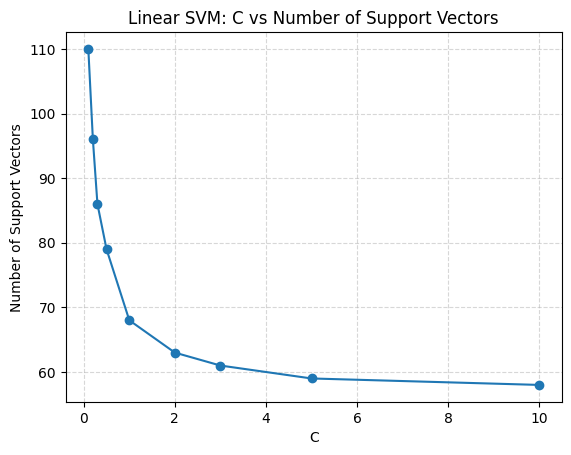

save graph file: svm_support_vectors_plot.png


In [53]:
plt.figure()
plt.plot(C_values, sv_counts, marker='o')
plt.xlabel("C")
plt.ylabel("Number of Support Vectors")
plt.title("Linear SVM: C vs Number of Support Vectors")
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("svm_support_vectors_plot.png", bbox_inches="tight", dpi=160)
plt.show()

print("save graph file: svm_support_vectors_plot.png")

As the regularization parameter C increases, the number of support vectors decreases.
This happens because a larger C places a stronger penalty on misclassified points, forcing the SVM to create a decision boundary that fits the training data more strictly. Consequently, fewer data point lie withing or violate the margin, resulting in a smaller set of support vectors.
In constrst, when C is small, the model allows a wider margin with more tolerance for misclassification, so more dta points become support vectors.

# (d) Using “train data 2025.csv” as training and “test data 2025.csv” as testing data, compare the performance of four different kernel functions:
linear, polynomial, radial basic function (Gaussian kernel), and Sigmoid.

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0)
    }


In [55]:
# range of hyperprameter exploration
C_list = [0.1, 0.2, 0.3, 1, 5, 10, 20, 100, 200, 1000]
degree_ls = [1, 2, 3, 4, 5]
coef0_ls = [0.0001, 0.001, 0.002, 0.01, 0.02, 0.1, 0.2, 0.3, 1, 2, 5, 10]
gamma_ls = [0.0001, 0.001, 0.002, 0.01, 0.02, 0.03, 0.1, 0.2, 1, 2, 3]

results = []
best_params_report = []


In [56]:
# Kernal functions: Linear, Polynomial, RBF, Sigmoid
gs_linear = GridSearchCV(SVC(), {"kernel":["linear"], "C":C_list}, scoring="f1", cv=5, n_jobs=-1)
gs_linear.fit(X_train, y_train)
results.append({"kernel":"linear", **evaluate(gs_linear.best_estimator_, X_test, y_test)})
best_params_report.append(("linear", gs_linear.best_params_, gs_linear.best_score_))

gs_poly = GridSearchCV(SVC(), {"kernel":["poly"], "C":C_list, "degree":degree_ls, "coef0":coef0_ls}, scoring="f1", cv=5, n_jobs=-1)
gs_poly.fit(X_train, y_train)
results.append({"kernel":"poly", **evaluate(gs_poly.best_estimator_, X_test, y_test)})
best_params_report.append(("poly", gs_poly.best_params_, gs_poly.best_score_))

gs_rbf = GridSearchCV(SVC(), {"kernel":["rbf"], "C":C_list, "gamma":gamma_ls}, scoring="f1", cv=5, n_jobs=-1)
gs_rbf.fit(X_train, y_train)
results.append({"kernel":"rbf", **evaluate(gs_rbf.best_estimator_, X_test, y_test)})
best_params_report.append(("rbf", gs_rbf.best_params_, gs_rbf.best_score_))

gs_sig = GridSearchCV(SVC(), {"kernel":["sigmoid"], "C":C_list, "coef0":coef0_ls, "gamma":gamma_ls}, scoring="f1", cv=5, n_jobs=-1)
gs_sig.fit(X_train, y_train)
results.append({"kernel":"sigmoid", **evaluate(gs_sig.best_estimator_, X_test, y_test)})
best_params_report.append(("sigmoid", gs_sig.best_params_, gs_sig.best_score_))


print("\nBest params per kernel (CV=5, scoring=F1):")
for name, params, cvf1 in best_params_report:
    print(f"  - {name:7s} | best_pramas={params} | cv_best_f1={cvf1:.4f}")



Best params per kernel (CV=5, scoring=F1):
  - linear  | best_pramas={'C': 10, 'kernel': 'linear'} | cv_best_f1=0.8449
  - poly    | best_pramas={'C': 0.1, 'coef0': 0.3, 'degree': 2, 'kernel': 'poly'} | cv_best_f1=0.8530
  - rbf     | best_pramas={'C': 0.2, 'gamma': 0.2, 'kernel': 'rbf'} | cv_best_f1=0.8600
  - sigmoid | best_pramas={'C': 200, 'coef0': 1, 'gamma': 0.03, 'kernel': 'sigmoid'} | cv_best_f1=0.8601


Both RBF and Sigmoid kernels achieved the highest F1-score (0.86) during cross-validation, slightly outperforming the Linear and Polynomial kernels. This indicates that nonlinear decision boundaries fit the data better than a purely linear model.
The RBG kernel, with moderate values of C (0.2) and gamma (0.2), effectively balances bias and variance, capturing complex relationships without overfitting.
The Sigmoid kernel performed comparably, but RBF is generally preferred because it is more stable and less sensitive to parameter scaling.